In [29]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import diverging_palette

import sklearn
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import (
    LogisticRegression,
    Lasso
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict
)

from sklearn.metrics import (
    accuracy_score, 
    precision_score, average_precision_score,
    precision_recall_curve,
    confusion_matrix, plot_confusion_matrix,
    roc_curve, roc_auc_score,
    classification_report
)

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=ConvergenceWarning)

# Load Dataset into DataFrame

In [2]:
url = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/Airline-Passenger-Satisfaction-Prediction/main/Data/df5.csv'
data = pd.read_csv(url)
data

,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,...,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
0,26.0,0.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,...,3.0,4.0,4.0,4.0,5.0,0.0,1.0,0.0,1.0,1.0
1,61.0,0.0,214.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,...,4.0,4.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0
2,47.0,2.0,1276.0,2.0,4.0,2.0,3.0,2.0,2.0,2.0,...,3.0,4.0,3.0,5.0,2.0,9.0,0.0,1.0,1.0,0.0
3,52.0,0.0,2035.0,4.0,3.0,4.0,4.0,5.0,5.0,5.0,...,5.0,5.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,1.0
4,20.0,2.0,1061.0,3.0,3.0,3.0,4.0,2.0,3.0,3.0,...,3.0,4.0,4.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43954,26.0,0.0,712.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,...,4.0,4.0,3.0,4.0,5.0,17.0,1.0,1.0,1.0,1.0
43955,57.0,2.0,867.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0,...,4.0,3.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,1.0
43956,60.0,0.0,1599.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,...,4.0,4.0,4.0,4.0,4.0,9.0,1.0,0.0,1.0,1.0
43957,50.0,2.0,1620.0,3.0,1.0,3.0,4.0,2.0,3.0,2.0,...,3.0,4.0,2.0,4.0,2.0,0.0,0.0,1.0,1.0,0.0


# Data Preparation

## Standardization of numeric variables

In [3]:
numeric_cols = ['Age', 'Flight_Distance','Departure_Delay_in_Minutes']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

## Handling Missing values

The satisfaction level of each feature should range from 1 to 5. 

If the rating is 0, that means the customer did not rate for this feature.


In [4]:
def list_column_values(df, number_of_values, print_all):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() <= number_of_values:
            print(f"{col.ljust(25)}" +  ' ==> ' + str(df[col].sort_values().unique().tolist()) )
        else:  
            if print_all=='True':
               print(f"{col.ljust(25)}" + ' ==> more than ' + str(number_of_values) + ' values')

In [5]:
list_column_values(data, data.shape[1],'True')

**Results:**

Age                       ==> more than 22 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 22 values
Inflight_wifi_service     ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Departure/Arrival_time_convenient ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Ease_of_Online_booking    ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure_Delay_in_Minutes ==> more t

In [6]:
incomplete = ['Inflight_wifi_service','Departure/Arrival_time_convenient',
              'Ease_of_Online_booking','Online_boarding','Leg_room_service']
(data[incomplete] == 0).sum()

Inflight_wifi_service                 67
Departure/Arrival_time_convenient    134
Ease_of_Online_booking                58
Online_boarding                       16
Leg_room_service                       1
dtype: int64

In [7]:
(data[incomplete] == 0).sum().sum()/data.shape[0]

0.00627857776564526

We should consider rating=0 as missing values as the customer did not provide any rating feedback.

Considering the total number of rows that contains missing ratings only takes up 0.6% of the dataset, we simply drop these observations.

In [8]:
data = data.loc[(data[incomplete] != 0).all(axis=1)]

list_column_values(data, data.shape[1],'True')

**Results:**

Age                       ==> more than 22 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 22 values
Inflight_wifi_service     ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure/Arrival_time_convenient ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Ease_of_Online_booking    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure_Delay_in_Minutes ==> more than 22 values
satisfactio

In [9]:
data.shape

(43756, 22)

# Splitting the Dataset

Identify features and target

In [10]:
X = data.drop(columns=['satisfaction'])
y = data['satisfaction']

## Train Test Split

In [11]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

N_train, _ = X_train.shape 
N_val_test,  _ = X_val_test.shape 

N_train, N_val_test

(35004, 8752)

## Test Validation Split

In [12]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 777)

N_val, _ = X_val.shape 
N_test,  _ = X_test.shape 

N_val, N_test

(4376, 4376)

In [13]:
data.columns

Index(['Age', 'Class', 'Flight_Distance', 'Inflight_wifi_service',
       'Departure/Arrival_time_convenient', 'Ease_of_Online_booking',
       'Gate_location', 'Food_and_drink', 'Online_boarding', 'Seat_comfort',
       'Inflight_entertainment', 'On-board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Inflight_service',
       'Cleanliness', 'Departure_Delay_in_Minutes', 'satisfaction',
       'Gender_Male', 'Customer_Type_Loyal Customer',
       'Type_of_Travel_Business travel'],
      dtype='object')

# Functions for Evaluation Metrics

### ROC Curve

In [14]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### PR Curve

In [15]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

### Classification Score

It gets the model and evaluates it for training and validation.

In [16]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))
        plot_confusion_matrix(clf,  X_val, clf.predict(X_val))
        print("End of validation Result\n")

### Model Results Comparison

In [17]:
model_comparison = pd.DataFrame(columns=['precision','recall','f1-score','support'])

def add_result(model_name, y_actual, y_pred):
    global model_comparison

    report = classification_report(y_actual, y_pred, output_dict=True)
    scores = pd.DataFrame(report['1.0'],index=[model_name])

    model_comparison = model_comparison.append(scores)
    
    print(model_comparison)

# Verify Class Balance

In [18]:
data['satisfaction'].value_counts()

1.0    23925
0.0    19831
Name: satisfaction, dtype: int64

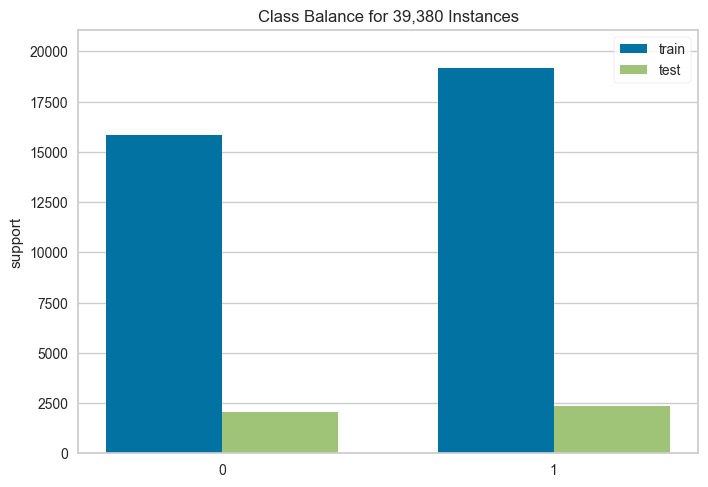

<AxesSubplot: title={'center': 'Class Balance for 39,380 Instances'}, ylabel='support'>

In [19]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_train, y_val)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Modelling

Baseline Model - DummyClassifier ✔

==========================

Feature Selection 
- LASSO (prefered)
- RFE

=====================

Regression:
- Logistics Regression

Neighbors:
- KNN

Naive Bayes:
- Gaussian

Ensemble Methods:
- Decision Tree
- Random Forest

===========================
- AdsBoost
- CatBoost
- Gradient Boosting
- Stacked generalization

Neural Nets:
- SVM
- Multi Layer Perception
- AdaNet

## Baseline Model - DummyClassifier

In [20]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train,y_train)

DummyClassifier()

Validation Result:

accuracy score: 0.5359



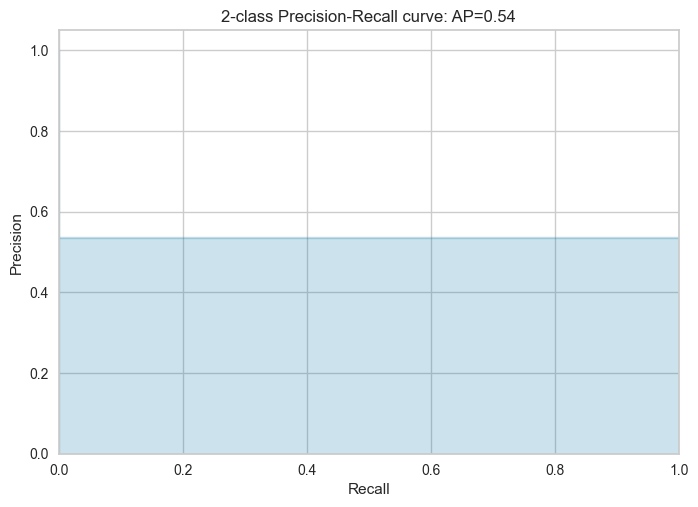

roc auc score: 0.5



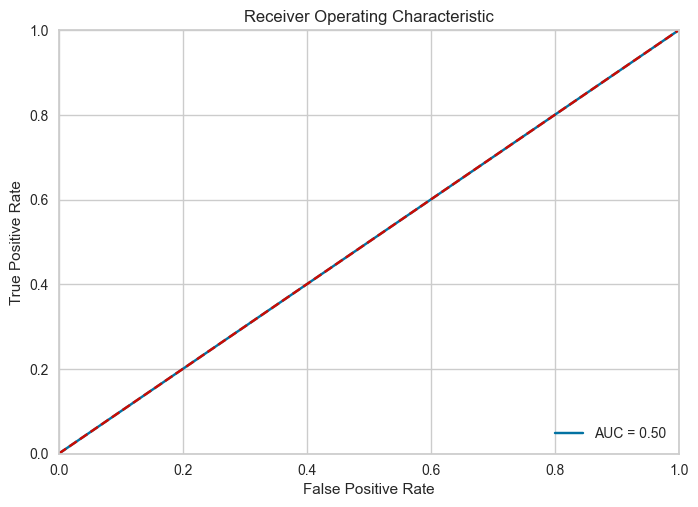

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2031
         1.0       0.54      1.00      0.70      2345

    accuracy                           0.54      4376
   macro avg       0.27      0.50      0.35      4376
weighted avg       0.29      0.54      0.37      4376


Confusion Matrix: 
 [[   0 2031]
 [   0 2345]]

End of validation Result



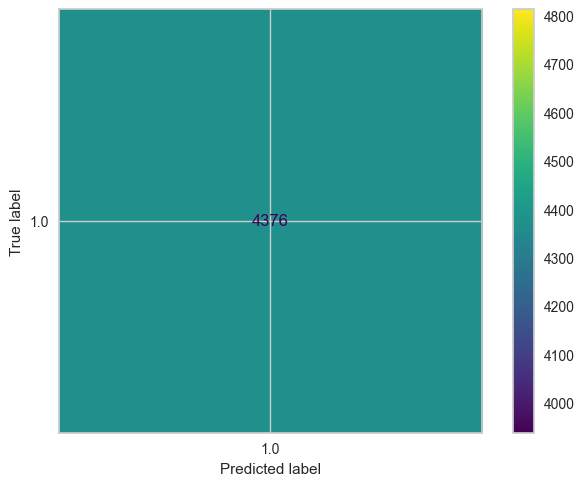

In [21]:
clf_score(dummy, X_train, y_train, X_val, y_val, train=False)

In [22]:
# Add result to model_comparison dataframe
model_name = 'DummyClassifier'
y_pred = dummy.predict(X_val)

add_result(model_name, y_val, y_pred)

                 precision  recall  f1-score support
DummyClassifier   0.535878     1.0  0.697813    2345


## Feature Selection

### 1. LASSO

In [23]:
lasso = Lasso(alpha=0.01)
model_lasso = lasso.fit(X_train, y_train)

In [24]:
model_lasso.coef_

array([ 0.00044513, -0.13973791,  0.01361016,  0.        , -0.00894538,
        0.        ,  0.00582552, -0.        ,  0.09717539,  0.03391091,
        0.0275149 ,  0.04385917,  0.03912013,  0.02210841,  0.03506695,
        0.01830838,  0.02908356, -0.00350892,  0.        ,  0.08976133,
        0.20718092])

In [25]:
pd.DataFrame(list(zip(X_train.columns,model_lasso.coef_)), columns = ['predictor','coefficient'])

,predictor,coefficient
0,Age,0.000445
1,Class,-0.139738
2,Flight_Distance,0.013610
3,Inflight_wifi_service,0.000000
4,Departure/Arrival_time_convenient,-0.008945
5,Ease_of_Online_booking,0.000000
6,Gate_location,0.005826
7,Food_and_drink,-0.000000
8,Online_boarding,0.097175
9,Seat_comfort,0.033911


### 2. RFE

In [26]:
from sklearn.feature_selection import RFE

lr = LogisticRegression(max_iter=5000)
rfe = RFE(lr, n_features_to_select=3) 
model_rfe = rfe.fit(X_train,y_train)

In [27]:
model_rfe.support_

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True,  True])

In [28]:
pd.DataFrame(list(zip(X_train.columns,model_rfe.ranking_)), 
             columns = ['predictor','ranking']).sort_values(by='ranking')

,predictor,ranking
10,Inflight_entertainment,1
19,Customer_Type_Loyal Customer,1
20,Type_of_Travel_Business travel,1
8,Online_boarding,2
1,Class,3
13,Baggage_handling,4
14,Checkin_service,5
11,On-board_service,6
16,Cleanliness,7
9,Seat_comfort,8


Based on the above results, we can drop 'Gender_Male', 'Gate_location', 'Inflight_wifi_service', 'Ease_of_Online_booking', 'Food_and_drink', 'Age'. 

X_train = X_train.drop(columns=['Gender_Male', 'Gate_location', 'Inflight_wifi_service', 'Ease_of_Online_booking', 'Food_and_drink', 'Age'])

## Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# define model
model = LogisticRegression()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2', 'elasticnet']

# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_train, y_train)

Validation Result:

accuracy score: 0.9340



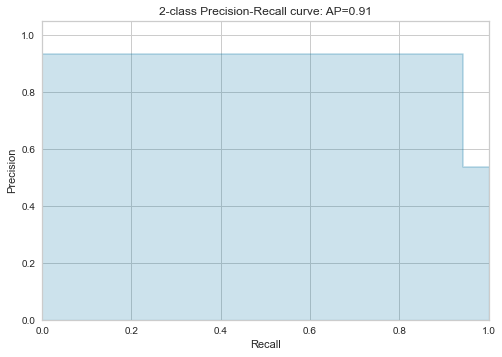

roc auc score: 0.9332040997796415



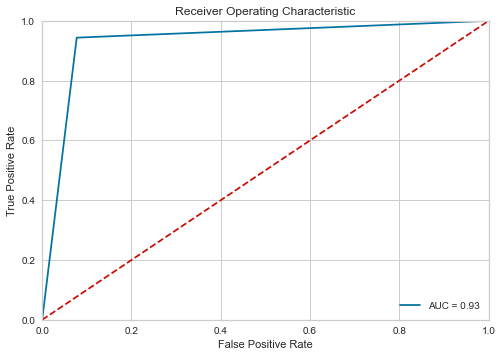

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.93      0.92      0.93      2031
         1.0       0.93      0.94      0.94      2345

    accuracy                           0.93      4376
   macro avg       0.93      0.93      0.93      4376
weighted avg       0.93      0.93      0.93      4376


Confusion Matrix: 
 [[1874  157]
 [ 132 2213]]

End of validation Result



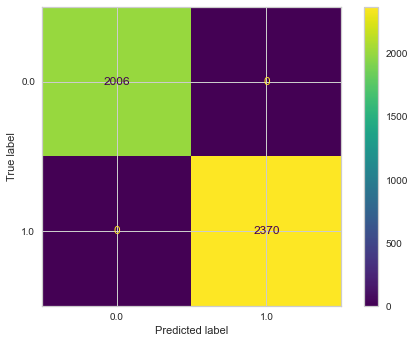

In [ ]:
clf_score(result, X_train, y_train, X_val, y_val, train=False)

In [ ]:
# Add result to model_comparison dataframe
model_name = 'LogisticRegression'
y_pred = result.predict(X_val)

add_result(model_name, y_val, y_pred)

                   precision   recall  f1-score support
DummyClassifier     0.535878      1.0  0.697813    2345
LogisticRegression  0.933755  0.94371  0.938706    2345


## K-Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

n_neighbors = list(range(2,10))

#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors)
#Create new KNN object
knn = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train,y_train)

Validation Result:

accuracy score: 0.9605



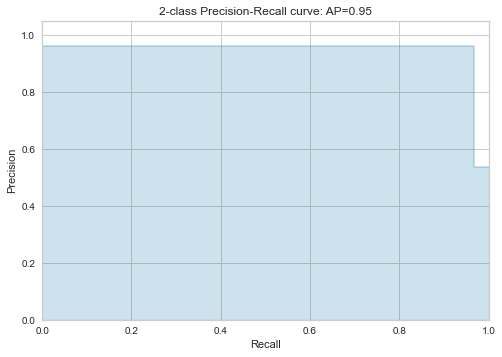

roc auc score: 0.9600143406201741



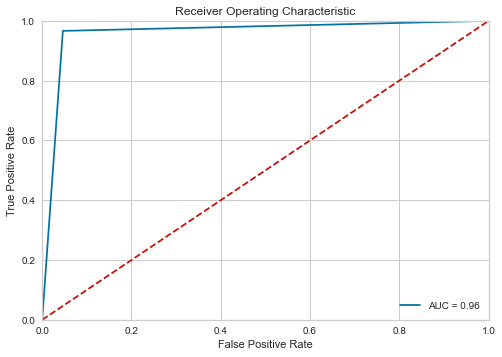

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      2031
         1.0       0.96      0.97      0.96      2345

    accuracy                           0.96      4376
   macro avg       0.96      0.96      0.96      4376
weighted avg       0.96      0.96      0.96      4376


Confusion Matrix: 
 [[1937   94]
 [  79 2266]]

End of validation Result



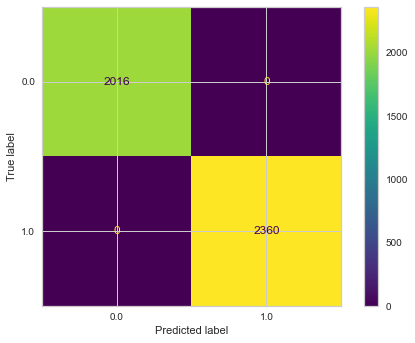

In [ ]:
clf_score(best_model, X_train, y_train, X_val, y_val, train=False)

In [ ]:
# Add result to model_comparison dataframe
model_name = 'KNN'
y_pred = best_model.predict(X_val)

add_result(model_name, y_val, y_pred)

                   precision    recall  f1-score support
DummyClassifier     0.535878       1.0  0.697813    2345
LogisticRegression  0.933755   0.94371  0.938706    2345
KNN                 0.960169  0.966311  0.963231    2345


## Naive Bayesian

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
model = GaussianNB()
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

best_model = gs_NB.fit(X_train,y_train)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


Validation Result:

accuracy score: 0.9205



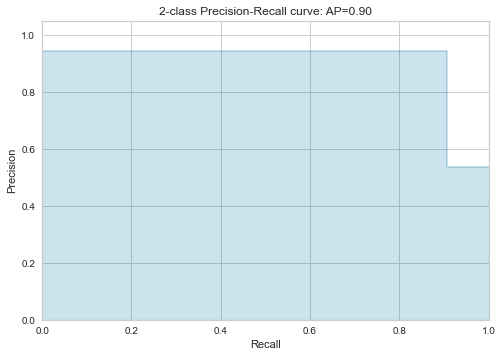

roc auc score: 0.9215801137801181



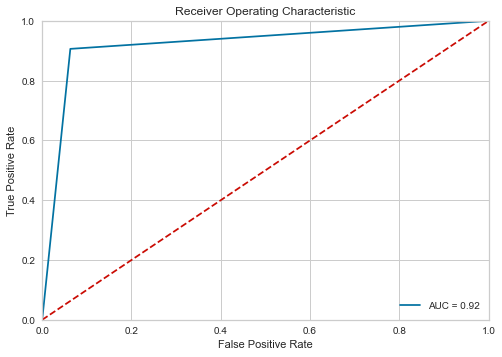

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.90      0.94      0.92      2031
         1.0       0.94      0.91      0.92      2345

    accuracy                           0.92      4376
   macro avg       0.92      0.92      0.92      4376
weighted avg       0.92      0.92      0.92      4376


Confusion Matrix: 
 [[1903  128]
 [ 220 2125]]

End of validation Result



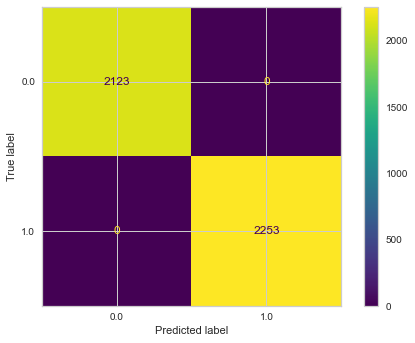

In [ ]:
clf_score(best_model, X_train, y_train, X_val, y_val, train=False)

In [ ]:
# Add result to model_comparison dataframe
model_name = 'Naive Bayesian'
y_pred = best_model.predict(X_val)

add_result(model_name, y_val, y_pred)

                   precision    recall  f1-score support
DummyClassifier     0.535878       1.0  0.697813    2345
LogisticRegression  0.933755   0.94371  0.938706    2345
KNN                 0.960169  0.966311  0.963231    2345
Naive Bayesian      0.943187  0.906183  0.924315    2345


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

Validation Result:

accuracy score: 0.9660



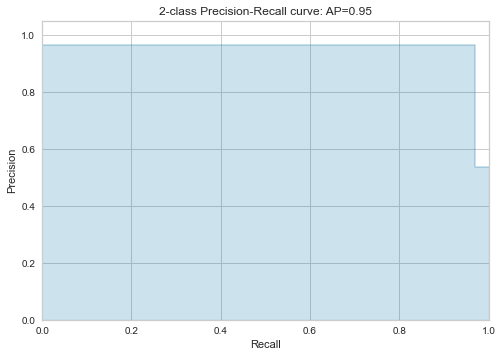

roc auc score: 0.9655931148225952



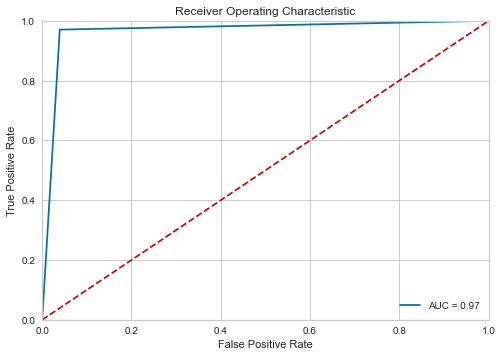

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      2031
         1.0       0.97      0.97      0.97      2345

    accuracy                           0.97      4376
   macro avg       0.97      0.97      0.97      4376
weighted avg       0.97      0.97      0.97      4376


Confusion Matrix: 
 [[1951   80]
 [  69 2276]]

End of validation Result



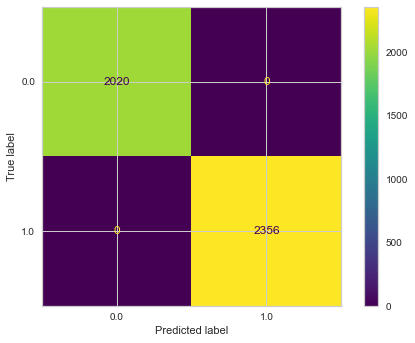

In [ ]:
clf_score(grid_search, X_train, y_train, X_val, y_val, train=False)

In [ ]:
# Add result to model_comparison dataframe
model_name = 'Decision Tree'
y_pred = grid_search.predict(X_val)

add_result(model_name, y_val, y_pred)

                   precision    recall  f1-score support
DummyClassifier     0.535878       1.0  0.697813    2345
LogisticRegression  0.933755   0.94371  0.938706    2345
KNN                 0.960169  0.966311  0.963231    2345
Naive Bayesian      0.943187  0.906183  0.924315    2345
Decision Tree       0.966044  0.970576  0.968305    2345


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 35, 60, 85, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 650, 1100, 1550,
                                                         2000]},
                   random_state=42)

In [ ]:
print(rf_random.best_params_)

{'n_estimators': 2000, 'max_features': 'sqrt', 'max_depth': 35, 'bootstrap': False}


Validation Result:

accuracy score: 0.9771



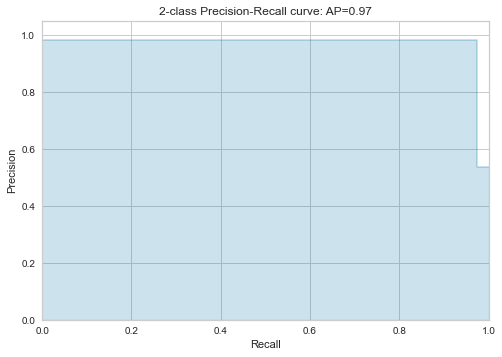

roc auc score: 0.9773264926685417



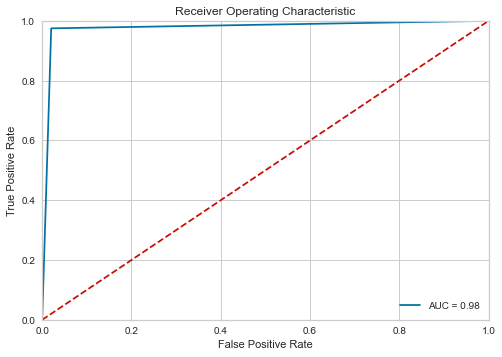

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      2031
         1.0       0.98      0.97      0.98      2345

    accuracy                           0.98      4376
   macro avg       0.98      0.98      0.98      4376
weighted avg       0.98      0.98      0.98      4376


Confusion Matrix: 
 [[1990   41]
 [  59 2286]]

End of validation Result



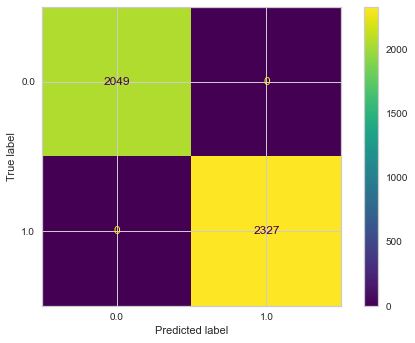

In [ ]:
clf_score(rf_random, X_train, y_train, X_val, y_val, train=False)

In [ ]:
# Add result to model_comparison dataframe
model_name = 'Random Forest'
y_pred = rf_random.predict(X_val)

add_result(model_name, y_val, y_pred)

                   precision    recall  f1-score support
DummyClassifier     0.535878       1.0  0.697813    2345
LogisticRegression  0.933755   0.94371  0.938706    2345
KNN                 0.960169  0.966311  0.963231    2345
Naive Bayesian      0.943187  0.906183  0.924315    2345
Decision Tree       0.966044  0.970576  0.968305    2345
Random Forest       0.982381   0.97484  0.978596    2345


## Adaboost

In [ ]:
# Add result to model_comparison dataframe
model_name = 'AdaBoost'
y_pred = #???

add_result(model_name, y_val, y_pred)

## LightGBM

## XGBoost

In [ ]:
# Add result to model_comparison dataframe
model_name = 'XGBoost'
y_pred = #???

add_result(model_name, y_val, y_pred)

## Stacked Generalization

## Support-Vector Machines